In [1]:
# ============================================
# SVM — Step 1: Load preprocessing
# ============================================

%run "./02_preprocessing.ipynb"

import numpy as np
import pandas as pd

from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\nClass distribution:\n", y_train.value_counts(normalize=True))


Initial shape: (15200, 15)
Exact duplicate rows: 192
Duplicate faculty_id: 8


,faculty_id,academic_rank,tenure_status,years_at_institution,base_salary,teaching_load,research_funding,institution_type,department_size,admin_support,work_life_balance,promotion_opportunities,publications_last_3_years,student_evaluation_avg,left_institution
0,10000,Associate Professor,Tenure-Track,17,67410.138471,2,-2604.167089,Technical Institute,23,4,3,6,4,2.971100,0
1,10001,Full Professor,Non-Tenure,6,65578.523052,1,5601.080853,Technical Institute,8,6,6,6,6,3.681743,0
2,10002,Lecturer,Tenured,22,70730.493594,1,65860.624649,Technical Institute,11,9,1,7,9,1.002227,1
3,10003,Associate Professor,Tenured,0,59283.503256,4,41557.812521,Technical Institute,22,5,7,9,4,2.420985,0
4,10004,Associate Professor,Tenure-Track,26,66641.452922,5,26096.583217,Liberal Arts College,49,9,5,5,9,3.261318,0


Train shape: (12006, 13)
Test shape: (3002, 13)

Train target distribution:
left_institution
0    0.760287
1    0.239713
Name: proportion, dtype: float64
Categorical columns: ['academic_rank', 'tenure_status', 'institution_type']
Numeric columns: ['years_at_institution', 'base_salary', 'teaching_load', 'research_funding', 'department_size', 'admin_support', 'work_life_balance', 'promotion_opportunities', 'publications_last_3_years', 'student_evaluation_avg']
Preprocessor fitted successfully!
Processed shape: (12006, 34)
X_train shape: (12006, 13)
X_test shape: (3002, 13)

Class distribution:
 left_institution
0    0.760287
1    0.239713
Name: proportion, dtype: float64


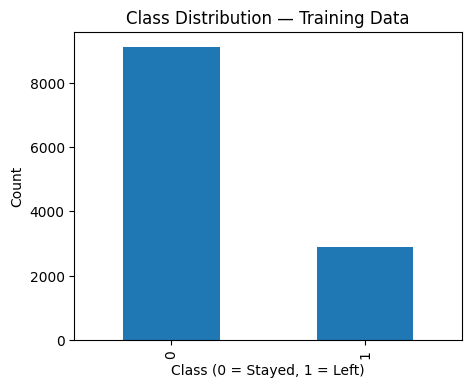

In [2]:
plt.figure(figsize=(5,4))
y_train.value_counts().plot(kind='bar')
plt.title("Class Distribution — Training Data")
plt.xlabel("Class (0 = Stayed, 1 = Left)")
plt.ylabel("Count")
plt.show()


In [3]:
# ============================================
# RBF SVM (SVC with probability=True)
# ============================================

svm_rbf = Pipeline([
    ("preprocess", preprocessor),
    ("svm", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced",
        probability=True
    ))
])

svm_rbf.fit(X_train, y_train)

y_pred_rbf = svm_rbf.predict(X_test)
y_prob_rbf = svm_rbf.predict_proba(X_test)[:, 1]

print("RBF SVM Accuracy:", accuracy_score(y_test, y_pred_rbf))
print("RBF SVM AUC:", roc_auc_score(y_test, y_prob_rbf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rbf))


RBF SVM Accuracy: 0.8747501665556295
RBF SVM AUC: 0.8967795467131126

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92      2283
           1       0.70      0.83      0.76       719

    accuracy                           0.87      3002
   macro avg       0.82      0.86      0.84      3002
weighted avg       0.88      0.87      0.88      3002



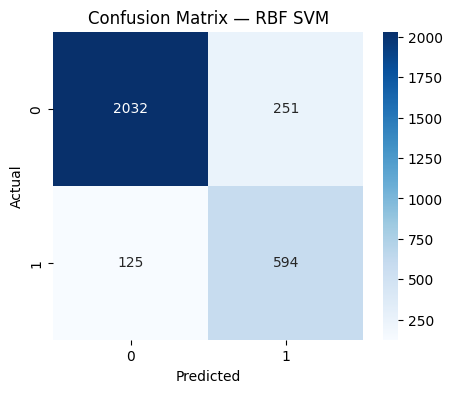

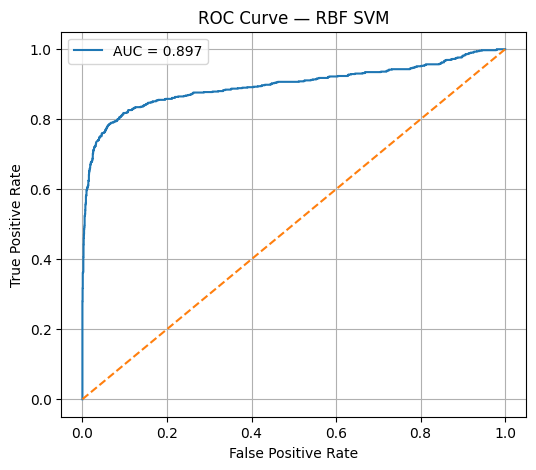

In [4]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rbf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — RBF SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rbf)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_rbf):.3f}")
plt.plot([0,1],[0,1],"--")
plt.title("ROC Curve — RBF SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# ============================================
# RBF SVM — Hyperparameter Tuning
# ============================================

from sklearn.model_selection import GridSearchCV

svm_rbf_tune = Pipeline([
    ("preprocess", preprocessor),
    ("svm", SVC(
        kernel="rbf",
        probability=True,
        class_weight="balanced"
    ))
])

param_grid_svm = {
    "svm__C": [0.1, 1, 5, 10],
    "svm__gamma": ["scale", 0.1, 0.01, 0.001]
}

grid_svm = GridSearchCV(
    estimator=svm_rbf_tune,
    param_grid=param_grid_svm,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1
)

grid_svm.fit(X_train, y_train)

print("Best Params:", grid_svm.best_params_)
print("Best CV AUC:", grid_svm.best_score_)


Best Params: {'svm__C': 1, 'svm__gamma': 'scale'}
Best CV AUC: 0.8940443130287865


Final SVM Accuracy: 0.8747501665556295
Final SVM AUC: 0.8967737592424383

Final Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92      2283
           1       0.70      0.83      0.76       719

    accuracy                           0.87      3002
   macro avg       0.82      0.86      0.84      3002
weighted avg       0.88      0.87      0.88      3002



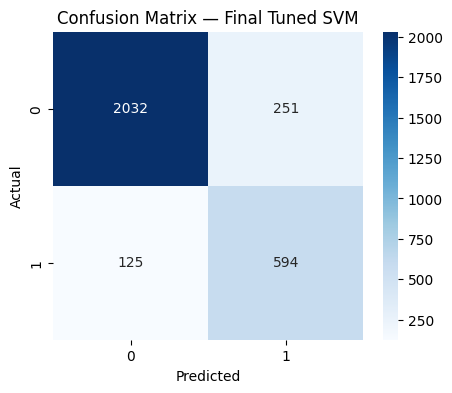

In [10]:
best_svm = grid_svm.best_estimator_

y_pred_svm_final = best_svm.predict(X_test)
y_prob_svm_final = best_svm.predict_proba(X_test)[:, 1]

print("Final SVM Accuracy:", accuracy_score(y_test, y_pred_svm_final))
print("Final SVM AUC:", roc_auc_score(y_test, y_prob_svm_final))
print("\nFinal Classification Report:\n", classification_report(y_test, y_pred_svm_final))

cm = confusion_matrix(y_test, y_pred_svm_final)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Final Tuned SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


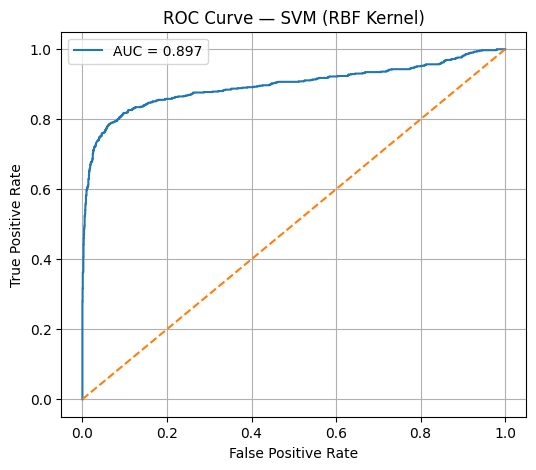

In [11]:
# ============================================
# ROC Curve — Final SVM
# ============================================

fpr, tpr, _ = roc_curve(y_test, y_prob_svm_final)
auc_svm = roc_auc_score(y_test, y_prob_svm_final)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_svm:.3f}')
plt.plot([0,1], [0,1], '--')
plt.title("ROC Curve — SVM (RBF Kernel)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


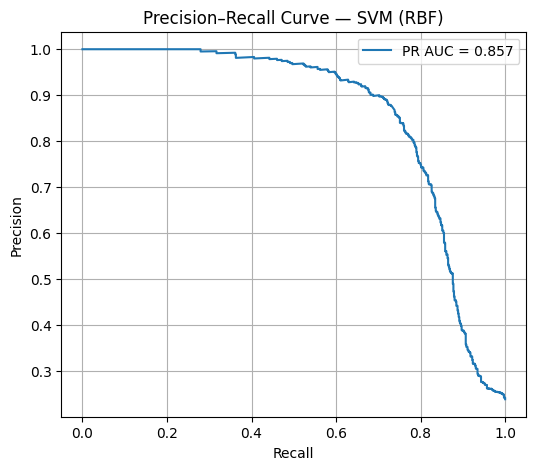

In [12]:
# ============================================
# Precision-Recall Curve — SVM
# ============================================
from sklearn.metrics import precision_recall_curve, auc
prec, rec, _ = precision_recall_curve(y_test, y_prob_svm_final)
pr_auc = auc(rec, prec)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f'PR AUC = {pr_auc:.3f}')
plt.title("Precision–Recall Curve — SVM (RBF)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()


In [14]:
# ============================================
# SAVE FINAL SVM MODEL
# ============================================

import joblib

final_svm_model = best_svm
joblib.dump(final_svm_model, "../models/svm_rbf.pkl")

print("Saved SVM RBF model as svm_rbf.pkl")


Saved SVM RBF model as svm_rbf.pkl
